Import all the necessary libraries

In [1]:
import sqlite3 as sql
import pandas as pd
import spacy
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import re
import tqdm
import tqdm as notebook_tqdm
from textblob import TextBlob
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jaysh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Step 1: Fetch all the necessary data from the database

In [2]:
# Connection with the database
def connect_to_db(db_path):
    try:
        conn = sql.connect(db_path)
        return conn
    except Exception as e:
        print(f"Error connecting to database: {e}")
        return None

# Fetch the data from the database
def fetch_text_data(conn):
    if conn is None:
        return pd.DataFrame()  # Return an empty DataFrame if connection failed
    query = 'SELECT * from content,links WHERE content.id = links.id'
    df = pd.read_sql_query(query, conn)
    return df

# Use the absolute path to the database file
db_path = 'C:/Users/jaysh/Documents/TFG/Code/data/processed/articles.db'
conn = connect_to_db(db_path)
df = fetch_text_data(conn)

if not df.empty:
    print('Data fetched from the database.')
        # Drop the duplicate 'id' column (assuming the second one is redundant)
    df = df.loc[:, ~df.columns.duplicated()]

    # Convert 'publish_date' to datetime format
    df["publish_date"] = pd.to_datetime(df["publish_date"])

    # Check the cleaned DataFrame
    print(df.info())

else:
    print("No data fetched from the database.")

Data fetched from the database.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3832 entries, 0 to 3831
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              3832 non-null   int64         
 1   title           3832 non-null   object        
 2   publish_date    3832 non-null   datetime64[ns]
 3   text            3832 non-null   object        
 4   outlier         3832 non-null   int64         
 5   truncated_text  3832 non-null   object        
 6   tokens          3832 non-null   object        
 7   clean_text      3832 non-null   object        
 8   clean_title     3832 non-null   object        
 9   newspaper       3832 non-null   object        
 10  url             3832 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(8)
memory usage: 329.4+ KB
None


# Step 2: Feature Extraction
This phase is composed by:
- Converting the text into Vectors
- Sentiment Analysis
- Stance Analysis
- N.E.R (Name Entity Recognition)
- Framing Bias


*CONVERTING THE TEXT INTO VECTORS*

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy.sparse

# Create TF-IDF Vectorizer for Unigrams, Bigrams, and Trigrams
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=5000)  # Limit to top 5000 features to reduce memory usage
tfidf_matrix = tfidf_vectorizer.fit_transform(df['clean_text'])  # Remain as a sparse matrix



In [8]:
# Store vectors row-by-row in a new column
df['text_vectors'] = [row for row in tfidf_matrix]


In [10]:
print(df['text_vectors'].head())
print(df['text_vectors'].shape)

0      (0, 3646)\t0.10845091699864563\n  (0, 2488)\...
1      (0, 4615)\t0.02840970218377131\n  (0, 4590)\...
2      (0, 4590)\t0.04145161448168438\n  (0, 4840)\...
3      (0, 4310)\t0.05827608163483878\n  (0, 165)\t...
4      (0, 3646)\t0.038316310956607244\n  (0, 4615)...
Name: text_vectors, dtype: object
(3832,)


*SENTIMENT ANALYSIS*

In [151]:
# Option 1: Use a lexicon-based approach
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
import nltk
nltk.download('vader_lexicon')
nltk.download('stopwords')

# Initialize VADER (note: primarily for English but sometimes works for Spanish)
sid = SentimentIntensityAnalyzer()

# Apply sentiment analysis
df['sentiment_score_vader'] = df['clean_text'].apply(
    lambda text: sid.polarity_scores(text)['compound'])

# Option 2: Simple lexicon-based approach with Spanish sentiment lexicons
# Load Spanish positive and negative words (you'll need to find a Spanish lexicon)
positive_words = set(open('spanish_positive_words.txt', 'r', encoding='utf-8').read().splitlines())
negative_words = set(open('spanish_negative_words.txt', 'r', encoding='utf-8').read().splitlines())

def simple_sentiment(text):
    words = text.split()
    pos_count = sum(1 for word in words if word in positive_words)
    neg_count = sum(1 for word in words if word in negative_words)
    
    if pos_count > neg_count:
        return 1
    elif neg_count > pos_count:
        return -1
    else:
        return 0

df['sentiment_score'] = df['clean_text'].apply(simple_sentiment)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\jaysh\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jaysh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [159]:
from sentiment_analysis_spanish import sentiment_analysis

# Initialize Sentiment Analyzer
analyzer = sentiment_analysis.SentimentAnalysisSpanish()

# Function to get sentiment score (0 = Negative, 1 = Positive)
def get_sentiment(text):
    try:
        return analyzer.sentiment(text)  # Returns a float between 0 (Negative) and 1 (Positive)
    except:
        return None  # If there's an issue with the text, return None

# Apply the sentiment analysis function
df['sentiment_score'] = df['clean_text'].apply(get_sentiment)

# Convert score from [0, 1] to [-1, 1]
df['sentiment_score'] = df['sentiment_score'].apply(lambda x: (x - 0.5) * 2 if x is not None else None)

# Classify sentiment based on score
def classify_sentiment(score):
    if score is None:
        return "UNKNOWN"
    elif score > 0.3:
        return "POS"
    elif score < -0.3:
        return "NEG"
    else:
        return "NEU"

df["sentiment"] = df["sentiment_score"].apply(classify_sentiment)

c:\Users\jaysh\anaconda3\envs\tfg_env\lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator CountVectorizer from version 0.23.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\jaysh\anaconda3\envs\tfg_env\lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MultinomialNB from version 0.23.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Text(0.5, 1.0, 'Sentiment Distribution')

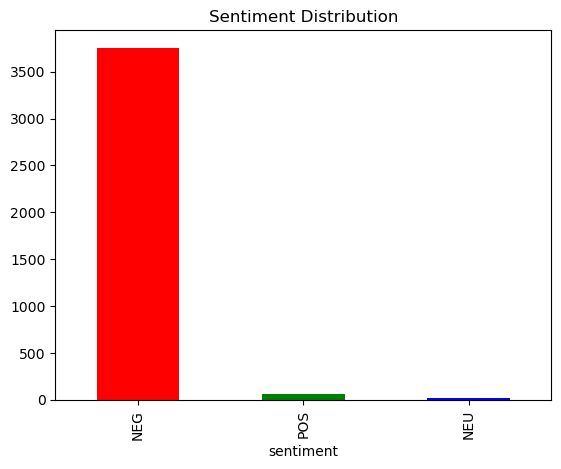

In [152]:
df['sentiment'].value_counts().plot(kind='bar', color=['red', 'green', 'blue'])
plt.title('Sentiment Distribution') 

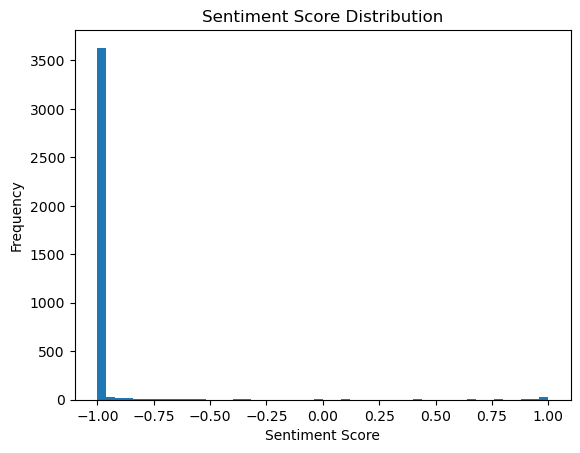

In [158]:
plot = df["sentiment_score"].plot(kind='hist', bins=50, title="Sentiment Score Distribution")
plot.set_xlabel("Sentiment Score")      
plot.set_ylabel("Frequency")
plt.show()

In [40]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

# Function to get sentiment score
def get_vader_sentiment(text):
    score = analyzer.polarity_scores(text)
    return score['compound']  # Range: [-1, 1]

df['sentiment_score_vader'] = df['clean_text'].apply(get_vader_sentiment)


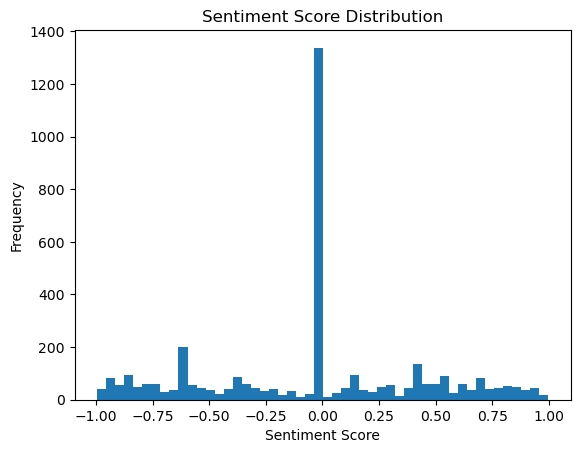

In [154]:
plot = df["sentiment_score_vader"].plot(kind='hist', bins=50, title="Sentiment Score Distribution")
plot.set_xlabel("Sentiment Score")      
plot.set_ylabel("Frequency")
plt.show()

*STANCE ANALYSIS*

Creation of a pro and anti inmigration lexicon dictionary

In [54]:
# Pro-Immigration Lexicon
pro_immigration_lexicon = [
    "inmigración", "migración", "emigración", "recién llegados", "nuevos vecinos",
    "diversidad cultural", "enriquecimiento social", "contribuyentes", "gente trabajadora",
    "refugiados", "asilados", "buscadores de asilo", "derechos humanos", "solidaridad",
    "acogida", "hospitalidad", "integración", "comunidad inclusiva", "movilidad humana",
    "ciudadanía global", "oportunidades", "esperanza", "futuro mejor", "intercambio cultural",
    "sociedad plural", "tolerancia", "entendimiento mutuo", "coexistencia pacífica",
    "tejido social", "arraigo", "humanidad compartida", "lazos familiares", "reunificación familiar",
    "apoyo", "ayuda humanitaria", "protección", "vulnerables", "necesitados", "amparo",
    "bienvenida", "puertas abiertas", "brazos abiertos", "unión", "fuerza laboral", "talento",
    "innovación", "desarrollo", "crecimiento", "progreso", "riqueza cultural", "patrimonio",
    "legado", "mestizaje", "sin fronteras", "mundo unido", "justicia", "equidad", "dignidad",
    "respeto", "empatía", "compasión", "apertura mental", "mente abierta", "sin prejuicios",
    "igualdad de oportunidades", "derecho a migrar", "libertad de movimiento", "movilidad laboral",
    "integración económica", "participación cívica", "voz", "presencia", "aporte", "valor",
    "ser humano", "persona", "individuo", "sueños", "aspiraciones", "historias", "vidas",
    "experiencias", "conocimiento", "riqueza de ideas", "perspectivas", "creatividad",
    "energía", "vitalidad", "dinamismo", "transformación", "evolución", "construcción",
    "fortalecimiento", "apoyo mutuo", "colaboración", "convivencia", "armonía", "paz",
    "un futuro para todos"
]

# Anti-Immigration Lexicon
anti_immigration_lexicon = [
    "inmigración ilegal", "inmigración masiva", "avalancha de inmigrantes",
    "oleada de inmigrantes", "inmigración descontrolada", "inmigrantes ilegales",
    "sin papeles", "indocumentados", "extranjeros ilegales", "invasión migratoria",
    "amenaza a la seguridad", "riesgo para la seguridad nacional", "fronteras porosas",
    "control fronterizo insuficiente", "delincuencia importada", "problemas sociales",
    "tensión social", "conflicto cultural", "choque cultural", "pérdida de identidad nacional",
    "amenaza a la cultura nacional", "reemplazo poblacional", "efecto llamada",
    "abuso de ayudas sociales", "carga para el estado", "gasto público excesivo",
    "competencia desleal", "bajada de salarios", "pérdida de empleos para nacionales",
    "colapso de servicios públicos", "saturación de hospitales", "saturación de escuelas",
    "problemas de vivienda", "marginalización", "guetización", "falta de integración",
    "dificultad de asimilación", "culturas incompatibles", "tradiciones diferentes",
    "valores opuestos", "amenaza a las costumbres", "peligro para la cohesión social",
    "fractura social", "división", "malestar ciudadano", "rechazo", "oposición",
    "expulsión", "deportación", "retorno", "cierre de fronteras", "endurecimiento de leyes",
    "restricción de la inmigración", "cupos limitados", "prioridad a nacionales",
    "protección del mercado laboral nacional", "defensa de la identidad nacional",
    "soberanía nacional amenazada", "intereses nacionales primero", "ilegalidad",
    "incumplimiento de la ley", "violación de la ley", "fraude", "engaño", "abuso",
    "explotación", "mafias", "redes ilegales", "tráfico de personas", "inseguridad jurídica",
    "vacío legal", "desorden", "caos", "ingobernabilidad", "problema", "amenaza", "peligro",
    "riesgo", "carga", "coste", "impacto negativo", "consecuencias negativas"
]

from sklearn.feature_extraction.text import TfidfVectorizer

# This is your tfidf_vectorizer and tfidf_matrix from earlier
feature_names = tfidf_vectorizer.get_feature_names_out()  # List of words indexed by their position

# Function to calculate lexicon score
def get_lexicon_score(matrix, feature_names, lexicon):
    indices = [i for i, word in enumerate(feature_names) if word in lexicon]
    lexicon_matrix = matrix[:, indices]
    return lexicon_matrix.sum(axis=1)  # Sum of TF-IDF scores of words in the lexicon

# Calculate Pro-Immigration and Anti-Immigration Scores
df['pro_immigration_score'] = get_lexicon_score(tfidf_matrix, feature_names, pro_immigration_lexicon)
df['anti_immigration_score'] = get_lexicon_score(tfidf_matrix, feature_names, anti_immigration_lexicon)


In [55]:
df[['clean_text', 'pro_immigration_score', 'anti_immigration_score']].head(10)


,clean_text,pro_immigration_score,anti_immigration_score
0,presidente joe biden terminando mandato todaví...,0.166368,0.158633
1,vida sucede línea recta veces enmaraña luchar ...,0.205310,0.080360
2,saliendo chicos mayores después tiempo centro ...,0.144416,0.086303
3,mismo día lalachus mostró estampa vaquilla gra...,0.302934,0.069893
4,primer disparo batalla donald trump ciudades s...,0.184045,0.129997
5,cámara representantes aprobó martes proyecto l...,0.228623,0.351707
6,rescate madre migrante hijo nacido travesía ru...,0.000000,0.000000
7,refugios organizaciones brindan atención migra...,0.086167,0.058470
8,papa francisco elegido cardenal robert mcelroy...,0.150760,0.126693
9,niños migrantes méxico cada vez comunes último...,0.181894,0.040867


In [133]:
df['anti_immigration_score'].describe()

count    3832.000000
mean        0.063177
std         0.083624
min         0.000000
25%         0.000000
50%         0.037098
75%         0.098669
max         0.619546
Name: anti_immigration_score, dtype: float64

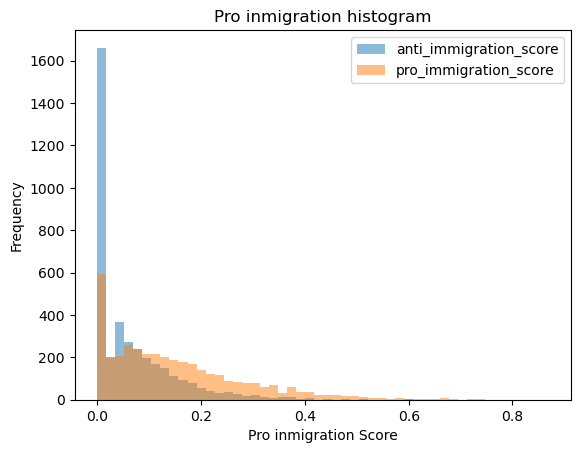

In [56]:
plot = df[["anti_immigration_score","pro_immigration_score"]].plot(kind='hist', bins=50, title="Pro inmigration histogram", alpha=0.5)
plot.set_xlabel("Pro inmigration Score")
plot.set_ylabel("Frequency")
plt.show()

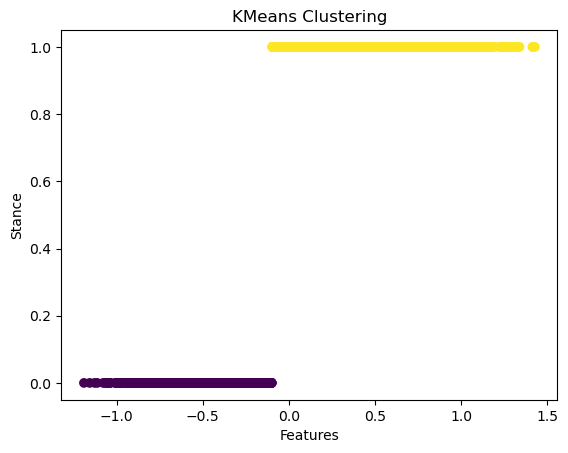

In [167]:
stance_score_jay=df['pro_immigration_score']-df['anti_immigration_score']
df['stance_score']=stance_score_jay
features = df["sentiment_score_vader"]+df["stance_score"]
features = features.values.reshape(-1, 1)
kmeans = KMeans(n_clusters=2, random_state=42).fit(features)
df["stance"] = kmeans.labels_

#visualise kmeans
plt.scatter(features, df["stance"], c=kmeans.labels_, cmap='viridis')
plt.xlabel("Features")
plt.ylabel("Stance")
plt.title("KMeans Clustering")
plt.show()

In [169]:
from sklearn.metrics import silhouette_score

# Calculate Silhouette Score (How well the points are separated)
silhouette_avg = silhouette_score(features, df["stance"])
print(f"Silhouette Score: {silhouette_avg:.4f}")

# Check Sentiment Distribution Per Cluster
for label in df['stance'].unique():
    cluster_sentiments = df[df['stance'] == label]['sentiment_score_vader']
    print(f"\nCluster {label} - Average Sentiment Score: {cluster_sentiments.mean():.4f}")


Silhouette Score: 0.5579

Cluster 0 - Average Sentiment Score: -0.5862

Cluster 1 - Average Sentiment Score: 0.2271


In [170]:
from collections import Counter
import spacy

# Load spaCy's Spanish model
nlp = spacy.load("es_core_news_sm")
nlp.max_length = 3_500_000  # Increase max length if needed

# Function to process text in chunks
def extract_entities_from_text(text, chunk_size=100000):
    entities = []
    for i in range(0, len(text), chunk_size):
        chunk = text[i:i+chunk_size]
        doc = nlp(chunk)
        entities.extend([ent.text for ent in doc.ents if len(ent.text) > 2])
    return entities

# Function to extract top words and entities from each cluster
def extract_topics_from_cluster(df, cluster_label):
    cluster_data = df[df['stance'] == cluster_label]
    text_data = ' '.join(cluster_data['clean_text'])
    
    # Count most common words
    word_counts = Counter(text_data.split())
    top_words = word_counts.most_common(20)
    
    # Extract Named Entities in chunks
    entities = extract_entities_from_text(text_data)
    entity_counts = Counter(entities).most_common(20)
    
    return top_words, entity_counts

# Get topics for each cluster
for label in df['stance'].unique():
    top_words, entity_counts = extract_topics_from_cluster(df, label)
    print(f"\n=== Cluster {label} ===")
    print("Top Words:", top_words)
    print("Top Entities:", entity_counts)



=== Cluster 0 ===
Top Words: [('personas', 2505), ('gobierno', 2263), ('inmigrantes', 1783), ('país', 1652), ('migrantes', 1651), ('inmigración', 1508), ('años', 1483), ('si', 1438), ('españa', 1378), ('dos', 1246), ('según', 1231), ('crisis', 1220), ('año', 1211), ('ser', 1205), ('menores', 1120), ('política', 1084), ('países', 1014), ('canarias', 1006), ('tras', 993), ('trump', 982)]
Top Entities: [('europa', 579), ('italia', 282), ('canarias', 270), ('alemania', 250), ('madrid', 236), ('pedro', 196), ('psoe', 178), ('francia', 163), ('ceuta', 161), ('marruecos', 147), ('eeuu', 122), ('melilla', 115), ('ucrania', 108), ('barcelona', 108), ('fernando', 103), ('llegó', 102), ('mauritania', 100), ('venezuela', 93), ('frontex', 90), ('reino unido', 88)]

=== Cluster 1 ===
Top Words: [('gobierno', 4094), ('personas', 4089), ('inmigración', 3144), ('inmigrantes', 3122), ('migrantes', 3081), ('si', 3030), ('país', 2699), ('años', 2693), ('españa', 2502), ('dos', 2449), ('menores', 2375), (

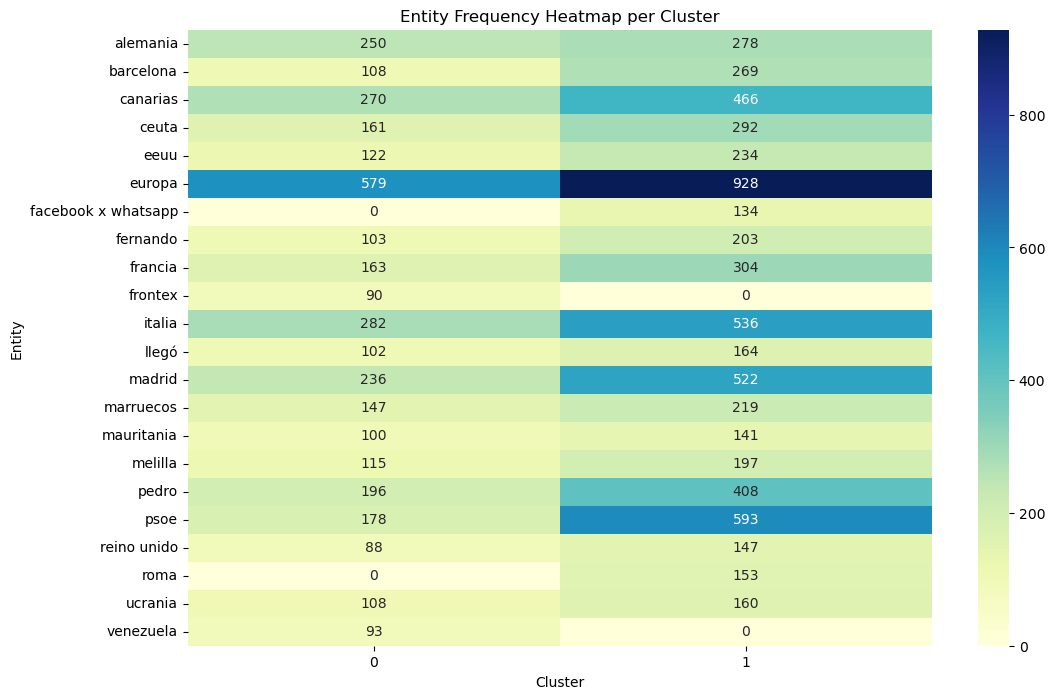

In [173]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you already have your extracted entities from each cluster
# Create a DataFrame for entities and their counts per cluster
entity_data = []

for label in df['stance'].unique():
    top_words, entity_counts = extract_topics_from_cluster(df, label)
    
    for entity, count in entity_counts:
        entity_data.append([entity, label, count])

# Convert to DataFrame
entity_df = pd.DataFrame(entity_data, columns=["Entity", "Cluster", "Count"])

# Pivot the table to prepare for heatmap visualization
entity_pivot = entity_df.pivot_table(index="Entity", columns="Cluster", values="Count", fill_value=0)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(entity_pivot, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Entity Frequency Heatmap per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Entity")
plt.show()


In [175]:
import pandas as pd

def analyze_clusters(df):
    cluster_analysis = []

    for label in df['stance'].unique():
        # Filter the data for the current cluster
        cluster_data = df[df['stance'] == label]

        # Calculate average sentiment score
        avg_sentiment = cluster_data['sentiment_score_vader'].mean()
        
        # Count total number of articles in the cluster
        total_articles = len(cluster_data)
        
        # Count most common entities
        entity_counts = Counter(' '.join(cluster_data['clean_text']).split()).most_common(20)

        # Append to analysis list
        cluster_analysis.append({
            "Cluster": label,
            "Total Articles": total_articles,
            "Average Sentiment Score": avg_sentiment,
            "Top Entities": entity_counts
        })

    # Convert to DataFrame
    cluster_analysis_df = pd.DataFrame(cluster_analysis)
    return cluster_analysis_df

# Perform analysis
cluster_analysis_df = analyze_clusters(df)

# Display the analysis
print(cluster_analysis_df)


   Cluster  Total Articles  Average Sentiment Score  \
0        0            1215                -0.586230   
1        1            2617                 0.227143   

                                        Top Entities  
0  [(personas, 2505), (gobierno, 2263), (inmigran...  
1  [(gobierno, 4094), (personas, 4089), (inmigrac...  


*N.E.R ANALYSIS*

In [ ]:
# Function to Extract Named Entities
import spacy 
nlp = spacy.load("es_core_news_sm")
def extract_entities(text):
    doc = nlp(text)
    persons = [ent.text for ent in doc.ents if ent.label_ == "PER"]
    locations = [ent.text for ent in doc.ents if ent.label_ == "LOC"]
    organizations = [ent.text for ent in doc.ents if ent.label_ == "ORG"]
    
    return persons, locations, organizations

# Apply function to all articles
df["persons"], df["locations"], df["organizations"] = zip(*df["text"].apply(extract_entities))

# Print first 10 results
print(df[["text", "persons", "locations", "organizations"]].head(10))


                                                text  \
0  El presidente Joe Biden está terminando su man...   
1  La vida no sucede en línea recta. A veces, tod...   
2  “Están saliendo chicos mayores después de esta...   
3  El mismo día que Lalachus mostró la estampa de...   
4  El primer disparo de la batalla de Donald Trum...   
5  La Cámara de Representantes aprobó el martes u...   
6  Rescate de una madre migrante y su hijo nacido...   
7  Los refugios y organizaciones que brindan aten...   
8  El Papa Francisco ha elegido al cardenal Rober...   
9  Los niños migrantes en México son cada vez más...   

                                             persons  \
0  [Joe Biden, Donald Trump, Nicolás Maduro, Madu...   
1  [Más, Paloma Sánchez-Garnica, vivió, Empezó De...   
2  [Lorena Morales, según, Elena Gil, Presupuesto...   
3  [Lalachus, Jesús, Mahmoud Bakhum, Mahmoud, Jes...   
4  [Donald Trump, llegó, Stephen Miller, Miller, ...   
5  [Donald Trump, Además, Laken Riley, Pennsylv

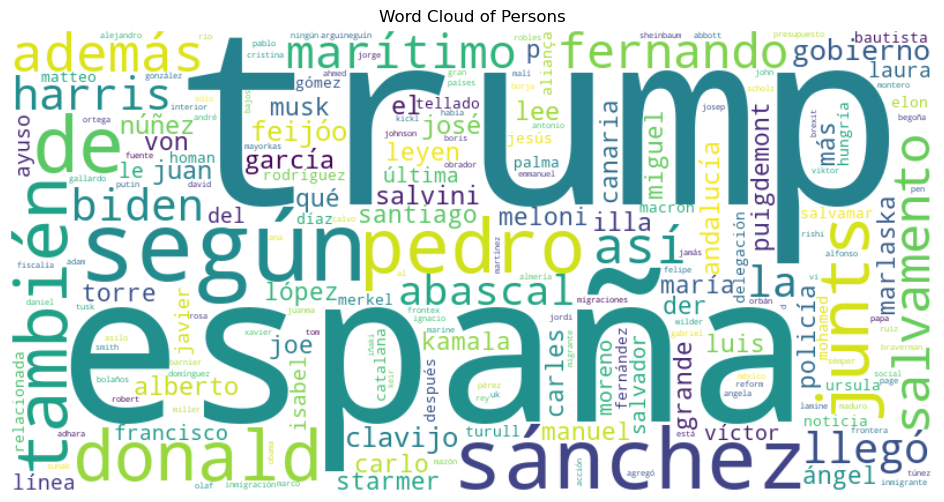

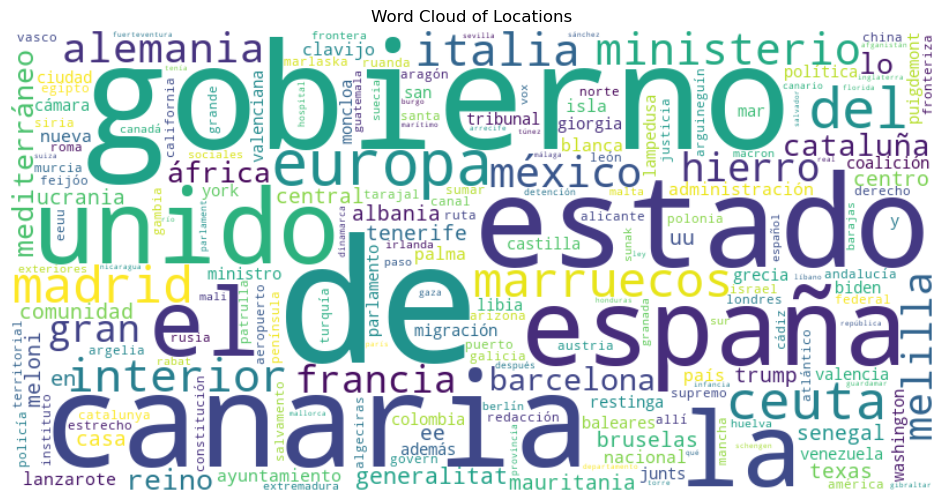

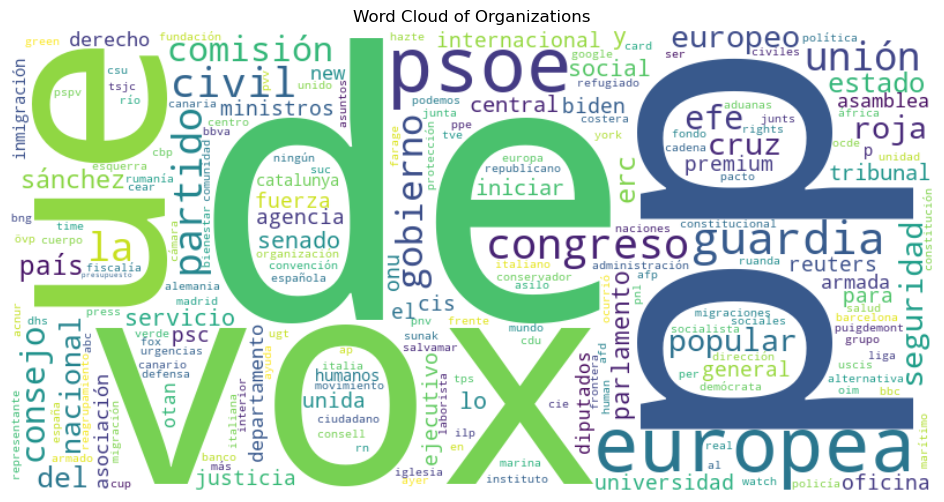

In [59]:
import string
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def normalize_entities(entity_list):
    # Convert all entities to lowercase and remove punctuation
    normalized_list = [entity.lower().strip(string.punctuation) for entity in entity_list]
    return normalized_list

def plot_wordcloud(df, entity_column, entity_type):
    all_entities = [item for sublist in df[entity_column] for item in sublist]
    normalized_entities = normalize_entities(all_entities)  # Normalize entities
    text = ' '.join(normalized_entities)
    
    wordcloud = WordCloud(width=800, height=400, background_color='white', collocations=False).generate(text)
    
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud of {entity_type}")
    plt.show()

# Plot Word Clouds with Normalization
plot_wordcloud(df, 'persons', 'Persons')
plot_wordcloud(df, 'locations', 'Locations')
plot_wordcloud(df, 'organizations', 'Organizations')


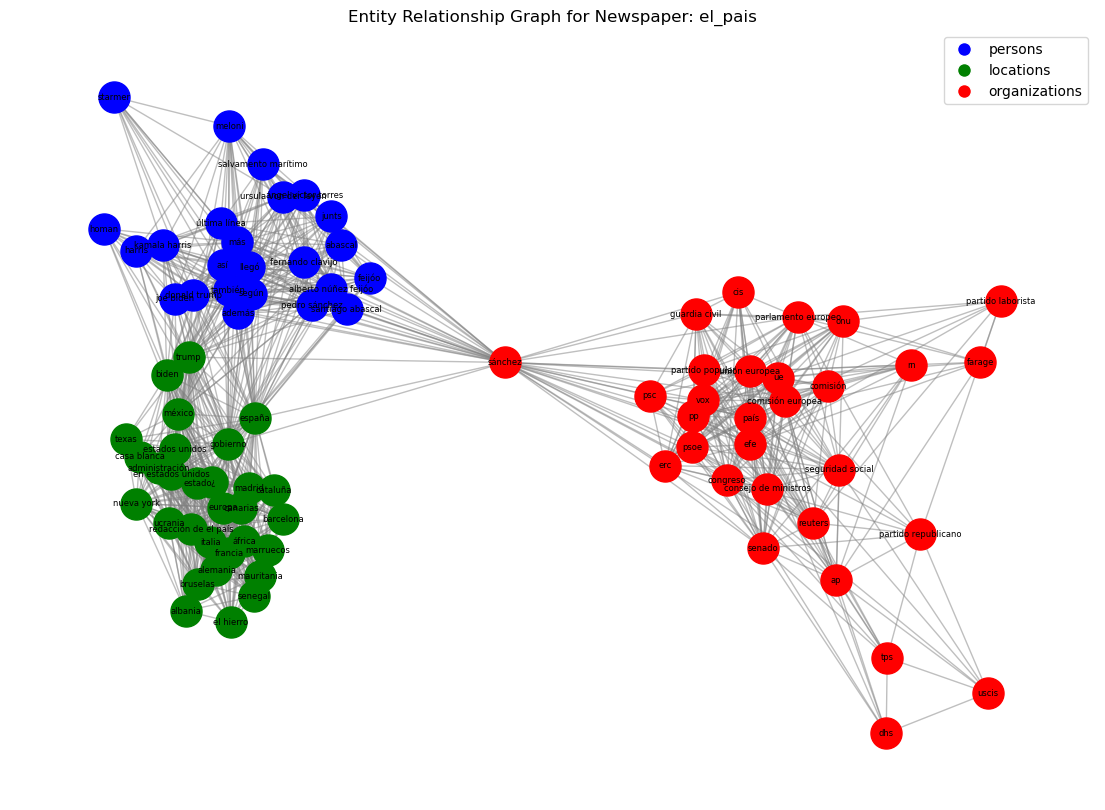

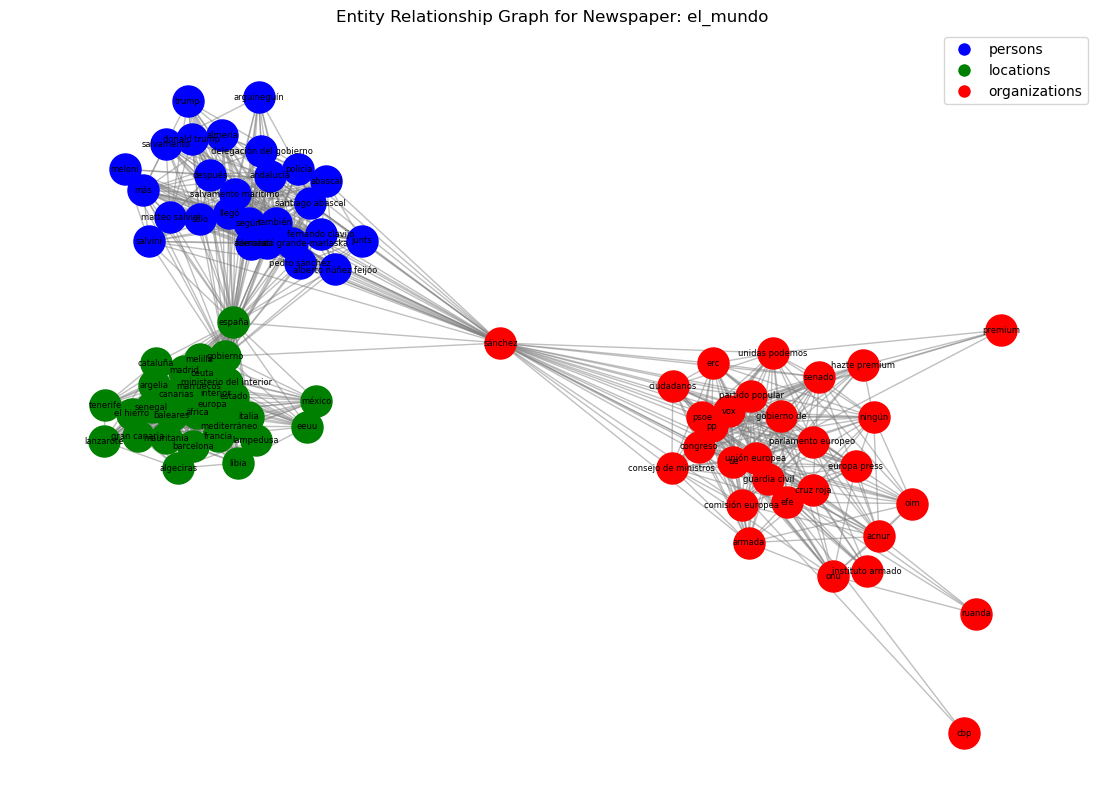

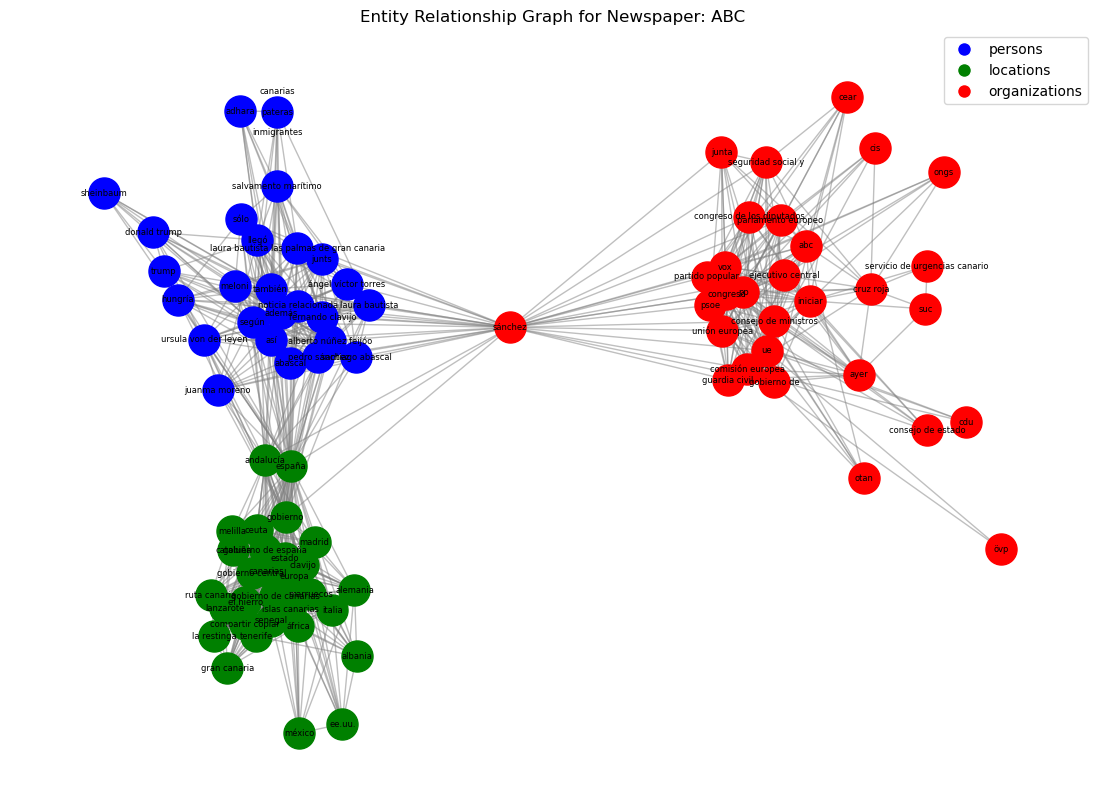

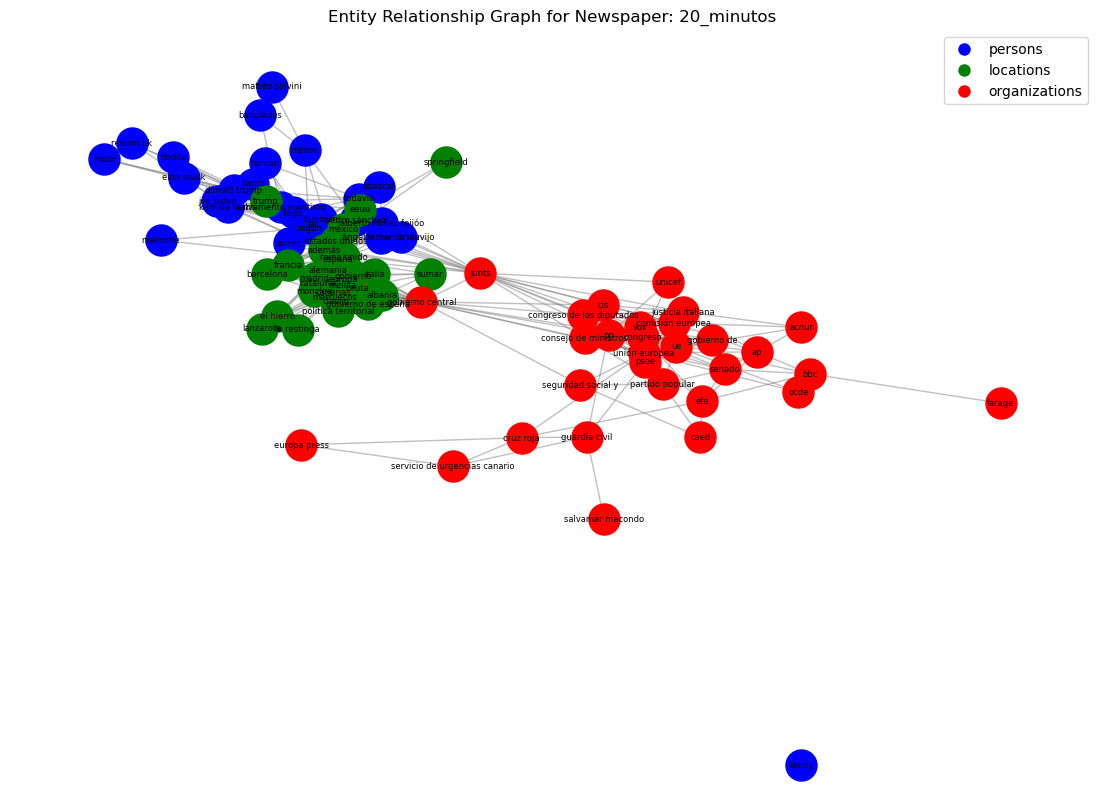

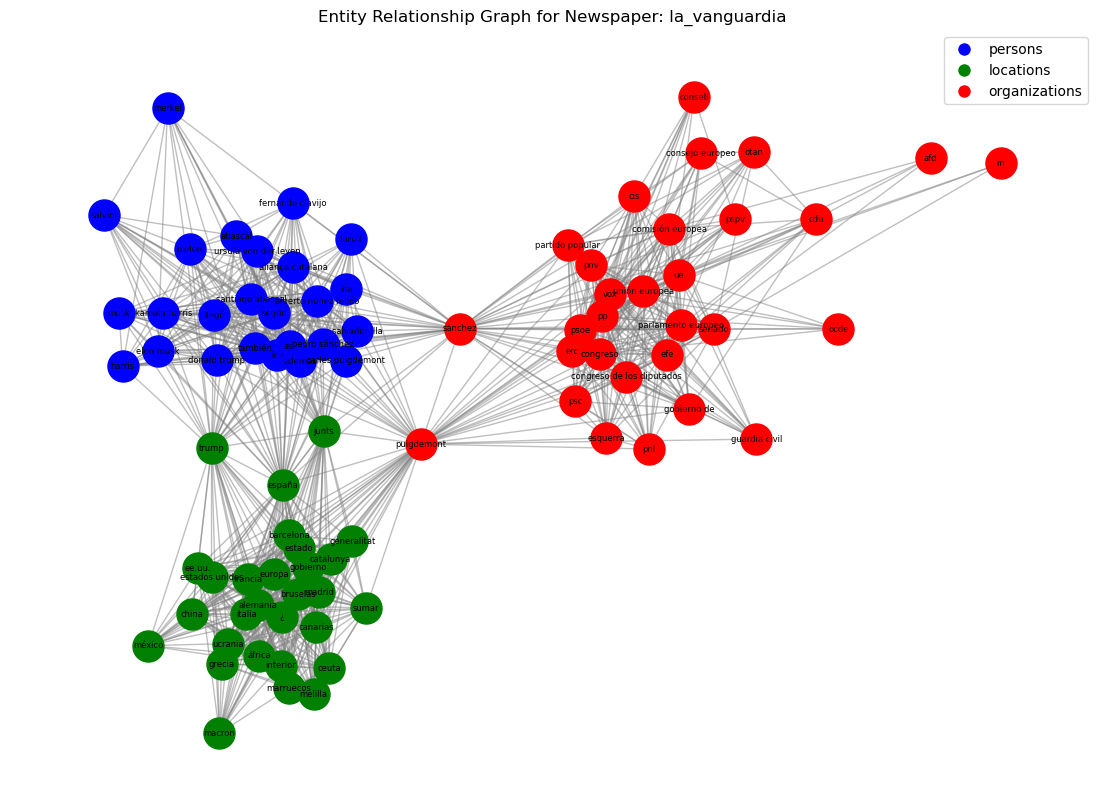

In [68]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
import random

def plot_network_by_newspaper(df, newspaper_column, top_n=15):
    # Define colors for each entity type
    entity_colors = {
        'persons': 'blue',
        'locations': 'green',
        'organizations': 'red'
    }

    # Get the list of unique newspapers
    newspapers = df[newspaper_column].unique()
    
    for newspaper in newspapers:
        # Filter the DataFrame for the current newspaper
        newspaper_df = df[df[newspaper_column] == newspaper]
        
        # Create a graph
        G = nx.Graph()
        
        # Process each entity type
        for entity_type, color in entity_colors.items():
            all_entities = [item for sublist in newspaper_df[entity_type] for item in sublist]
            normalized_entities = [entity.lower().strip() for entity in all_entities]
            entity_counts = Counter(normalized_entities).most_common(top_n)
            top_entities = [entity for entity, count in entity_counts]

            # Add nodes
            for entity in top_entities:
                G.add_node(entity, label=entity_type, color=color)
        
            # Add edges between entities that co-occur in the same article
            for _, row in newspaper_df.iterrows():
                entities_in_article = {entity.lower().strip() for entity in row[entity_type] if entity.lower().strip() in top_entities}
                
                for entity1 in entities_in_article:
                    for entity2 in entities_in_article:
                        if entity1 != entity2:
                            if G.has_edge(entity1, entity2):
                                G[entity1][entity2]['weight'] += 1
                            else:
                                G.add_edge(entity1, entity2, weight=1)
        
        # Plotting the network graph
        plt.figure(figsize=(14, 10))  # Increase figure size
        pos = nx.fruchterman_reingold_layout(G, scale=2, k=0.2, seed=42)

        
        # Draw nodes by color
        for entity_type, color in entity_colors.items():
            node_list = [node for node, attr in G.nodes(data=True) if attr['label'] == entity_type]
            nx.draw_networkx_nodes(G, pos, nodelist=node_list, node_color=color, label=entity_type, node_size=500)
        
        # Draw edges
        nx.draw_networkx_edges(G, pos, alpha=0.5, edge_color='gray')
        

        nx.draw_networkx_labels(G, pos, font_size=6, verticalalignment='center')

        
        
        plt.title(f"Entity Relationship Graph for Newspaper: {newspaper}")
        plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', label=label, markersize=10, markerfacecolor=color) 
                            for label, color in entity_colors.items()])
        plt.axis('off')
        plt.show()

# Plot Network Graphs by Newspaper
plot_network_by_newspaper(df, 'newspaper', top_n=30)
